In [372]:
# assessment data:
# https://www.eea.europa.eu/publications/status-of-air-quality-in-Europe-2022/europes-air-quality-status-2022/world-health-organization-who-air
# https://powietrze.gios.gov.pl/pjp/content/annual_assessment_air_acceptable_level

# *data:
# https://powietrze.gios.gov.pl/pjp/current/station_details/archive/402
# for October 2023 Krakow - ul. Bulwarowa
# * in exported csv, CO values are in mg/m3 not ug/m3

In [373]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skfuzzy import control as ctrl

In [374]:
pm10_safe_limit = 50 # 1h -> ug/m3
pm25_safe_limit = 25 # 1h -> ug/m3

In [375]:
# create df
column_names = ["Date Time", "PM10", "PM25"]
df = pd.read_csv("gios-pjp-data.csv", sep=",", skiprows=1, header=None)
df = df.iloc[:, :-4]
df.columns = column_names
df[column_names[1:]] = df[column_names[1:]].replace(r"^\s*$", np.nan, regex=True)
df = df.dropna()
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%Y-%m-%d %H:%M")
df["PM10"] = df["PM10"].astype(float)
df["PM25"] = df["PM25"].astype(float)

df.head(30)

,Date Time,PM10,PM25
0,2023-10-01 01:00:00,18.9,25.8
1,2023-10-01 02:00:00,18.9,25.2
2,2023-10-01 03:00:00,19.2,25.3
3,2023-10-01 04:00:00,21.9,28.5
4,2023-10-01 05:00:00,21.0,25.5
5,2023-10-01 06:00:00,23.3,28.9
6,2023-10-01 07:00:00,20.0,26.1
7,2023-10-01 08:00:00,16.5,21.1
8,2023-10-01 09:00:00,16.1,20.9
9,2023-10-01 10:00:00,15.2,20.3


In [376]:
column_names_wind = ["Date", "Wind"]
df_wind = pd.read_csv("wind.csv", sep=",", header=None)
df_wind = df_wind.iloc[:, :-1]
df_wind.columns = column_names_wind
df_wind["Date"] = pd.to_datetime(df_wind["Date"], format="%d.%m.%Y")
df_wind["Wind"] = df_wind["Wind"].astype(float)
df_wind.head()

,Date,Wind
0,2023-10-01,1.2
1,2023-10-02,1.5
2,2023-10-03,2.8
3,2024-10-04,4.5
4,2024-10-05,3.1


In [377]:
df_wind = df_wind.resample('D', on='Date')['Wind'].mean()
df_hourly_wind = []
for date, avg_wind in zip(df_wind.index, df_wind):
    df_hourly_wind.extend([(date + pd.Timedelta(hours=i), avg_wind) for i in range(24)])
column_names_hourly = ["Date Time", "Wind"]
df_hourly_wind = pd.DataFrame(df_hourly_wind, columns=column_names_hourly)
df_hourly_wind.head()

,Date Time,Wind
0,2023-10-01 00:00:00,1.2
1,2023-10-01 01:00:00,1.2
2,2023-10-01 02:00:00,1.2
3,2023-10-01 03:00:00,1.2
4,2023-10-01 04:00:00,1.2


In [378]:
df = pd.merge(df, df_hourly_wind, left_on="Date Time", right_on="Date Time", how="left")
df.head()

,Date Time,PM10,PM25,Wind
0,2023-10-01 01:00:00,18.9,25.8,1.2
1,2023-10-01 02:00:00,18.9,25.2,1.2
2,2023-10-01 03:00:00,19.2,25.3,1.2
3,2023-10-01 04:00:00,21.9,28.5,1.2
4,2023-10-01 05:00:00,21.0,25.5,1.2


In [379]:
df["PM10"] = np.where(df["PM10"] > pm10_safe_limit, pm10_safe_limit, df["PM10"])
df["PM25"] = np.where(df["PM25"] > pm25_safe_limit, pm25_safe_limit, df["PM25"])

pm10_max = df["PM10"].max()
pm25_max = df["PM10"].max()
df.describe()

,Date Time,PM10,PM25,Wind
count,744,744.000000,744.000000,71.000000
mean,2023-10-16 12:30:00.000000256,18.698253,19.723387,1.842254
min,2023-10-01 01:00:00,1.000000,1.000000,1.200000
25%,2023-10-08 18:45:00,9.700000,14.700000,1.200000
50%,2023-10-16 12:30:00,16.600000,22.550000,1.500000
75%,2023-10-24 06:15:00,24.000000,25.000000,2.800000
max,2023-11-01 00:00:00,50.000000,25.000000,2.800000
std,NaN,11.444898,6.236824,0.700135


In [380]:
step_size = 0.01

In [381]:
good = "good"
moderate = "moderate"
unhealthy = "unhealthy"

c:\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


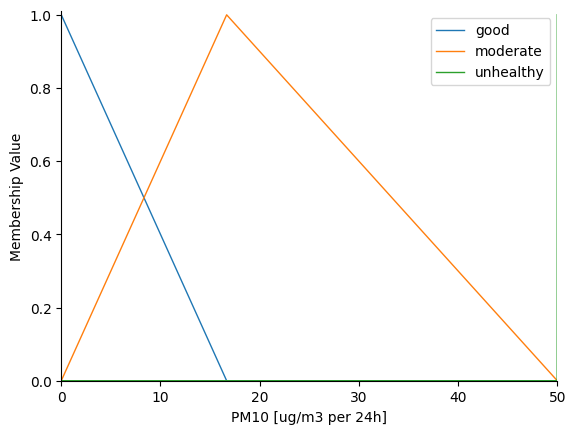

In [382]:
pm10 = ctrl.Antecedent(np.arange(0, pm10_max + step_size, step_size), "pm10")
pm10[good] = fuzz.trimf(pm10.universe, [0, 0, pm10_safe_limit / 3])
pm10[moderate] = fuzz.trimf(pm10.universe, [0, pm10_safe_limit / 3, pm10_safe_limit])
pm10[unhealthy] = fuzz.trapmf(pm10.universe, [pm10_safe_limit, pm10_safe_limit, pm10_max, pm10_max])
pm10.view()

plt.xlabel("PM10 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

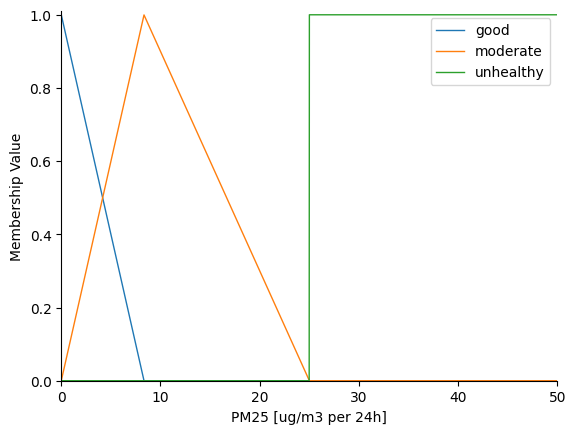

In [383]:
pm25 = ctrl.Antecedent(np.arange(0, pm25_max + step_size, step_size), "pm25")
pm25[good] = fuzz.trimf(pm25.universe, [0, 0, pm25_safe_limit / 3])
pm25[moderate] = fuzz.trimf(pm25.universe, [0, pm25_safe_limit / 3, pm25_safe_limit])
pm25[unhealthy] = fuzz.trapmf(pm25.universe, [pm25_safe_limit, pm25_safe_limit, pm25_max, pm25_max])
pm25.view()

plt.xlabel("PM25 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

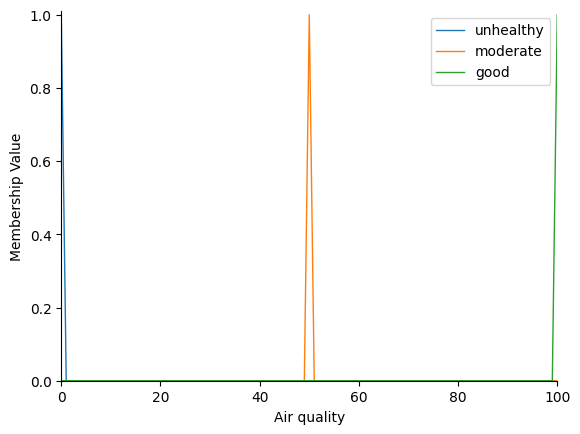

In [384]:
air_quality = ctrl.Consequent(np.arange(0, 101, 1), 'air_quality', defuzzify_method="centroid")
air_quality['unhealthy'] = fuzz.trimf(air_quality.universe, [0, 0, 0])
air_quality['moderate'] = fuzz.trimf(air_quality.universe, [50, 50, 50])
air_quality['good'] = fuzz.trimf(air_quality.universe, [100, 100, 100])
air_quality.view()

plt.xlabel("Air quality")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [385]:
rule1 = ctrl.Rule(pm10[unhealthy] & pm25[unhealthy],  air_quality[unhealthy])
rule2 = ctrl.Rule(pm10[good] & pm25[unhealthy],  air_quality[unhealthy])
rule3 = ctrl.Rule(pm10[moderate] & pm25[unhealthy],  air_quality[unhealthy])
rule4 = ctrl.Rule(pm10[unhealthy] & pm25[good],  air_quality[unhealthy])
rule5 = ctrl.Rule(pm10[unhealthy] & pm25[moderate],  air_quality[unhealthy])
rule6 = ctrl.Rule(pm10[good] & pm25[good],  air_quality[good])
rule7 = ctrl.Rule(pm10[moderate] & pm25[moderate],  air_quality[moderate])
rule8 = ctrl.Rule(pm10[good] & pm25[moderate],  air_quality[good])
rule9 = ctrl.Rule(pm10[moderate] & pm25[good],  air_quality[moderate])

In [386]:
air_quality_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
air_quality_sim = ctrl.ControlSystemSimulation(air_quality_ctrl)

In [387]:
num_of_points = 150
pm10_values = np.linspace(0, pm10_max, num_of_points)
pm25_values = np.linspace(0, pm25_max, num_of_points)
pm10_mesh, pm25_mesh= np.meshgrid(pm10_values, pm25_values)
air_quality_values = np.zeros_like(pm10_mesh)

In [388]:
def compute(defuzzify_method):
    air_quality.defuzzify_method = defuzzify_method
    for i in range(len(pm10_values)):
        for j in range(len(pm25_values)):
            air_quality_sim.input['pm10'] = pm10_values[i]
            air_quality_sim.input['pm25'] = pm25_values[j]
            air_quality_sim.compute()
            air_quality_values[i, j] = air_quality_sim.output['air_quality']

In [389]:
def display_3d_plot_pm(xlabel, ylabel, zlabel, azim):
    fig = plt.figure(figsize=(15, 15))

    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(pm10_mesh, pm25_mesh, air_quality_values, cmap='RdYlGn')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    ax.view_init(azim=azim)

    plt.show()

def display_3d_plot_pm(ax, xlabel, ylabel, zlabel, azim):
    ax.plot_surface(pm10_mesh, pm25_mesh, air_quality_values, cmap='RdYlGn')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.view_init(azim=azim)

In [390]:
# compute("centroid")
# display_3d_plot_pm("pm10", "pm2.5", "air quality", 60)

# compute("bisector")
# display_3d_plot_pm("pm10", "pm2.5", "air quality", 60)

# compute("mom")
# display_3d_plot_pm("pm10", "pm2.5", "air quality", 60)

# compute("som")
# display_3d_plot_pm("pm10", "pm2.5", "air quality", 60)

# compute("lom")
# display_3d_plot_pm("pm10", "pm2.5", "air quality", 60)

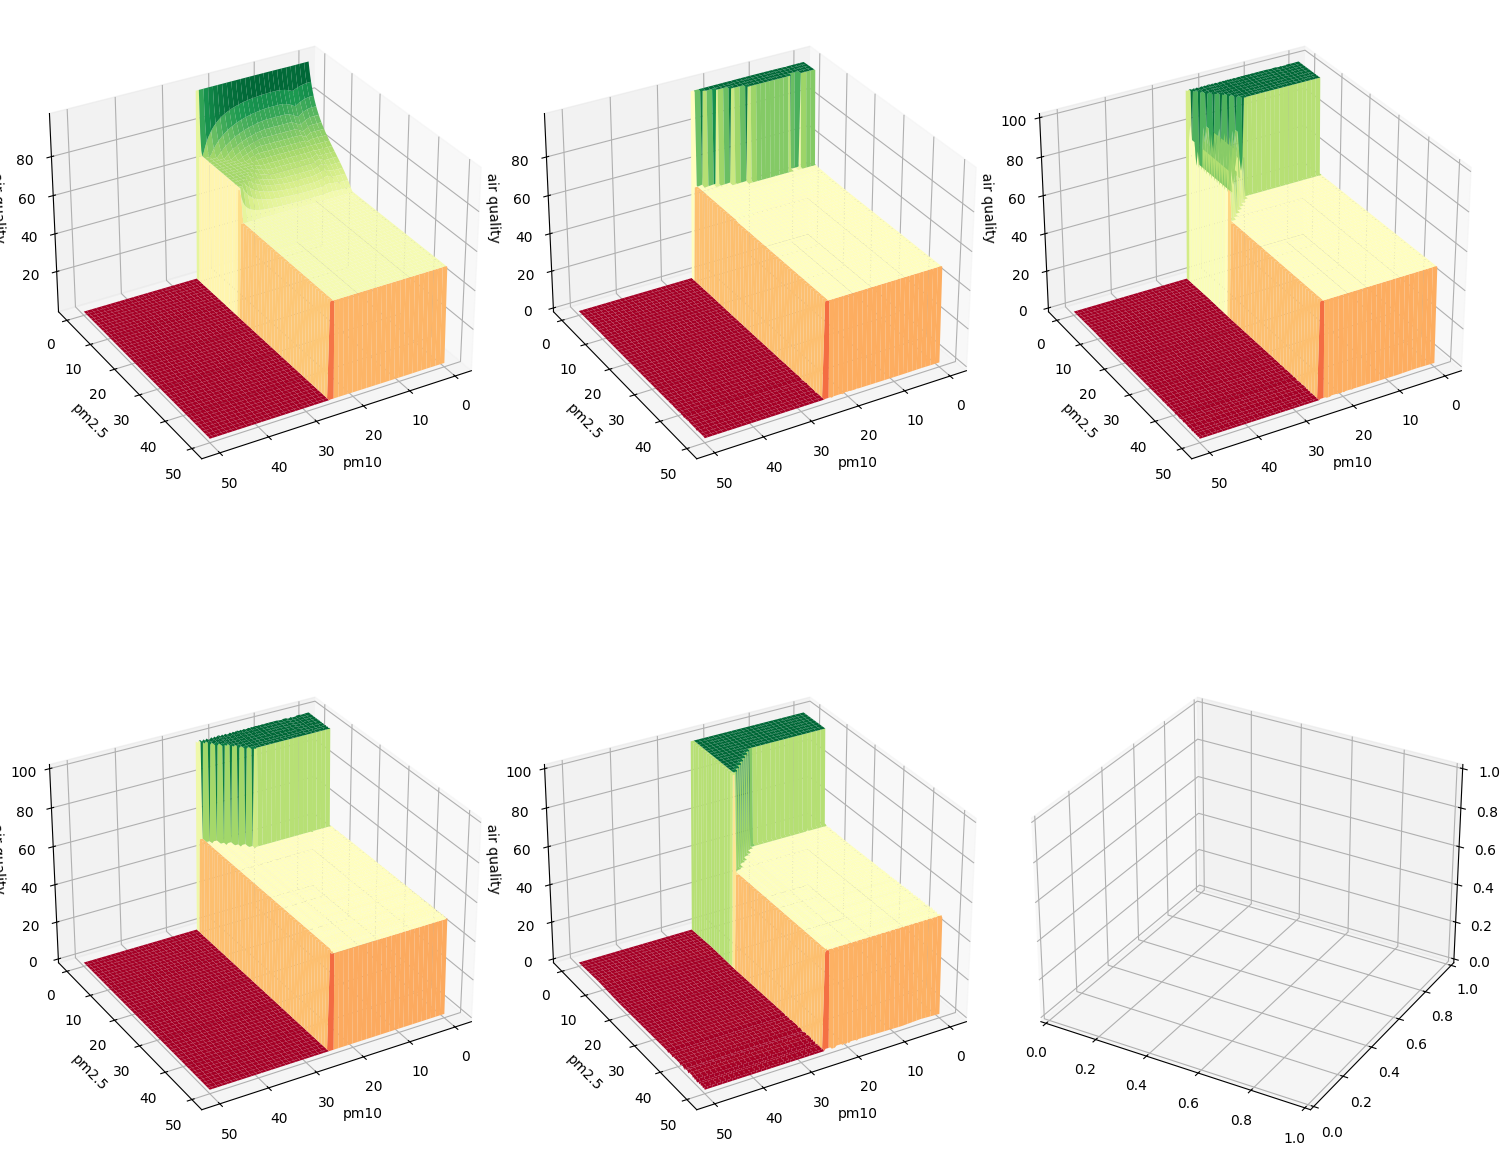

In [395]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})
methods = ["centroid", "bisector", "mom", "som", "lom"]

for i, method in enumerate(methods):
    row, col = divmod(i, 3)
    ax = axs[row, col]
    compute(method)
    display_3d_plot_pm(ax, "pm10", "pm2.5", "air quality", 60)
plt.tight_layout()

plt.show()